In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
#!conda install -c conda-forge beautifulsoup4
from bs4 import BeautifulSoup
#!conda install -c conda-forge lxml
import requests
from geopy.geocoders import Nominatim
#!conda install -c conda-forge folium=0.5.0 --yes 
#import folium
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Capstone Project: Recommendation of new tenant(s) to a commercial plaza
## 1. [Introduction/Business Problem](#part1)
## 2. [Data](#part2)
## 3. [Methodology](#part3)
## 4. [Results](#part4)
## 5. [Discussion](#part5)
## 6. [Conclusion](#part6)

<a id='part1'></a>
# 1. Introduction/Business Problem
## A client recently bought a commercial plaza in Lanham, Maryland. Most of the units in the plaza have already been under contract, but there is still one unit empty. He need to find a tenant to rent out the empty unit. In this data science project, I will recommend a venue (category) or a few venues (categories) for him to look into as his potential future tenant(s).
## This problem could be interesting to landlords of commercial properties or developers of a new community/neighborhood.

<a id='part2'></a>
# 2. Data
## The client's property is in Lanham, Maryland, which belongs to Prince George (PG) county. <br> So first, scrape all the cities/towns/Census-designated places in PG county from a Wikipedia page (https://en.wikipedia.org/wiki/Prince_George%27s_County,_Maryland#Communities)

In [26]:
source=requests.get('https://en.wikipedia.org/wiki/Prince_George%27s_County,_Maryland#Communities').text
soup=BeautifulSoup(source,'lxml')
#print(soup.prettify())

In [27]:
prince_george_county=soup.find_all('li')#,class_='div-col columns column-width')
towns=[]
for item in prince_george_county:
    try:
        towns.append(item.a.text+', MD')
    except:
        pass
index_first=towns.index('Bowie, MD')
index_last=towns.index('Woodmore, MD')
prince_towns=towns[index_first:index_last]
len(prince_towns)

81

## Next, in order to utilize Foursquare location data, use Geocoder Python package to get the latitude and longitude for each city/town.

In [36]:
lat=[]
lng=[]
geolocator=Nominatim(user_agent='md_pg_county')
for address in prince_towns:
    location=geolocator.geocode(address,timeout=500)
    try:
        print(address)
        lat.append(location.latitude)
        lng.append(location.longitude)
        
    except:
        lat.append(None)
        lng.append(None)

Bowie, MD
College Park, MD
District Heights, MD
Glenarden, MD
Greenbelt, MD
Hyattsville, MD
Laurel, MD
Mount Rainier, MD
New Carrollton, MD
Seat Pleasant, MD
Berwyn Heights, MD
Bladensburg, MD
Brentwood, MD
Capitol Heights, MD
Cheverly, MD
Colmar Manor, MD
Cottage City, MD
Eagle Harbor, MD
Edmonston, MD
Fairmount Heights, MD
Forest Heights, MD
Landover Hills, MD
Morningside, MD
North Brentwood, MD
Riverdale Park, MD
University Park, MD
Upper Marlboro, MD
Accokeek, MD
Adelphi, MD
Andrews AFB, MD
Aquasco, MD
Baden, MD
Beltsville, MD
Brandywine, MD
Brock Hall, MD
Calverton, MD
Camp Springs, MD
Cedarville, MD
Chillum, MD
Clinton, MD
Coral Hills, MD
Croom, MD
East Riverdale, MD
Fairwood, MD
Forestville, MD
Fort Washington, MD
Friendly, MD
Glassmanor, MD
Glenn Dale, MD
Hillandale, MD
Hillcrest Heights, MD
Kettering, MD
Konterra, MD
Lake Arbor, MD
Landover, MD
Langley Park, MD
Lanham, MD
Largo, MD
Marlboro Meadows, MD
Marlboro Village, MD
Marlow Heights, MD
Marlton, MD
Melwood, MD
Mitchellvil

## Create a pandas dataframe with columns of town, latitude, and longitude.
### - Note that the latitude and longitude are not available for some places. Just ignore them.

In [37]:
df_town=pd.DataFrame({'Town':prince_towns,'Latitude':lat,'Longitude':lng},columns=['Town','Latitude','Longitude'])
df_town.dropna(subset=['Latitude','Longitude'],inplace=True)
df_town.shape

(79, 3)

## Visualize the cities/towns on the map.

In [41]:
# create map 
address='4400 Forbes Blvd, Lanham, MD'
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
map_pg_county = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for latitude, longitude, label in zip(df_town['Latitude'], df_town['Longitude'], df_town['Town']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pg_county)  
    
map_pg_county

### -Drop a few towns that are too close to another city/town

In [39]:
drop_list=['Brentwood, MD','Marlow Heights, MD','Forest Heights, MD','Edmonston, MD','New Carrollton, MD',
           'Cottage City, MD','Seat Pleasant, MD']
df_town=df_town[df_town['Town'].map(lambda x: x not in drop_list)].reset_index(drop=True)
df_town.shape

(72, 3)

In [47]:
project.save_data(data=df_town.to_csv(index=False),file_name='pg_town.csv',overwrite=True)

{'file_name': 'pg_town.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstoneproject-donotdelete-pr-njpc9scr6dmzpe',
 'asset_id': 'c3e7b583-c170-45da-a1a3-cfab017754cc'}

## Use Foursquare location data to get venue information in all the cities/towns in PG county.

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
pg_town=pd.read_csv(project.get_file('pg_town.csv'))
pg_town.head()

,Town,Latitude,Longitude
0,"Bowie, MD",38.942966,-76.731234
1,"College Park, MD",38.980666,-76.936919
2,"District Heights, MD",38.857613,-76.889417
3,"Glenarden, MD",38.929278,-76.861639
4,"Greenbelt, MD",38.993733,-76.883066


In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=1200,LIMIT=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        try: 
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [7]:
pg_venues = getNearbyVenues(names=pg_town['Town'],
                                 latitudes=pg_town['Latitude'],
                                 longitudes=pg_town['Longitude']
                                )
pg_venues.head()

Bowie, MD
College Park, MD
District Heights, MD
Glenarden, MD
Greenbelt, MD
Hyattsville, MD
Laurel, MD
Mount Rainier, MD
Berwyn Heights, MD
Bladensburg, MD
Capitol Heights, MD
Cheverly, MD
Colmar Manor, MD
Eagle Harbor, MD
Fairmount Heights, MD
Landover Hills, MD
Morningside, MD
North Brentwood, MD
Riverdale Park, MD
University Park, MD
Upper Marlboro, MD
Accokeek, MD
Adelphi, MD
Andrews AFB, MD
Aquasco, MD
Baden, MD
Beltsville, MD
Brandywine, MD
Calverton, MD
Camp Springs, MD
Cedarville, MD
Chillum, MD
Clinton, MD
Coral Hills, MD
Croom, MD
East Riverdale, MD
Fairwood, MD
Forestville, MD
Fort Washington, MD
Friendly, MD
Glassmanor, MD
Glenn Dale, MD
Hillandale, MD
Hillcrest Heights, MD
Kettering, MD
Konterra, MD
Lake Arbor, MD
Landover, MD
Langley Park, MD
Lanham, MD
Largo, MD
Marlboro Meadows, MD
Marlboro Village, MD
Marlton, MD
Melwood, MD
Mitchellville, MD
National Harbor, MD
Oxon Hill, MD
Peppermill Village, MD
Queen Anne, MD
Rosaryville, MD
Seabrook, MD
Silver Hill, MD
South Laure

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bowie, MD",38.942966,-76.731234,Barnes & Noble,38.944206,-76.735447,Bookstore
1,"Bowie, MD",38.942966,-76.731234,Five Guys,38.943590,-76.734322,Burger Joint
2,"Bowie, MD",38.942966,-76.731234,Five Below,38.941971,-76.736021,Miscellaneous Shop
3,"Bowie, MD",38.942966,-76.731234,A.C. Moore Arts & Crafts,38.941518,-76.735489,Arts & Crafts Store
4,"Bowie, MD",38.942966,-76.731234,Red Robin Gourmet Burgers and Brews,38.944233,-76.732983,Burger Joint


In [8]:
pg_venues.shape

(2049, 7)

In [67]:
pg_venues.groupby('Venue').count().shape

(1228, 6)

In [62]:
pg_venues.groupby('Venue Category').count().shape

(240, 6)

## Data Filtering: Only consider popular venues/venue categories

[]

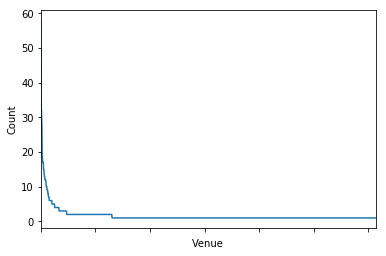

In [10]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
pg_venues.groupby('Venue')['Neighborhood'].count().sort_values(ascending=False).plot()
ax.set_ylabel('Count')
ax.set_xticklabels('')

In [66]:
venue_numbers=pg_venues.groupby('Venue').count().shape[0]
venue_5=(pg_venues.groupby('Venue')['Neighborhood'].count().sort_values(ascending=False)>=5).sum()
print('There are {} venues in the explored area of PG county, where only {} have 5 or more locations'.format(venue_numbers,venue_5))

There are 1228 venues in the explored area of PG county, where only 51 have 5 or more locations


[]

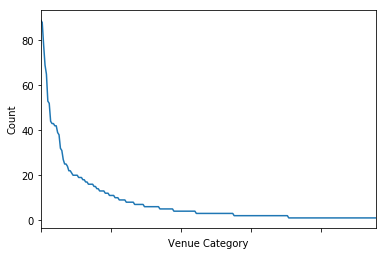

In [12]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
pg_venues.groupby('Venue Category')['Neighborhood'].count().sort_values(ascending=False).plot()
ax.set_ylabel('Count')
ax.set_xticklabels('')

In [13]:
venue_cat_numbers=pg_venues.groupby('Venue Category').count().shape[0]
venue_cat_10=(pg_venues.groupby('Venue Category')['Neighborhood'].count().sort_values(ascending=False)>=10).sum()
print('There are {} venue categories in the explored area of PG county, where {} have 10 or more locations'.format(venue_cat_numbers,venue_cat_10))

There are 240 venue categories in the explored area of PG county, where 56 have 10 or more locations


## Use Foursquare location data to get venue information near the client's shopping plaza

In [14]:
address='4400 Forbes Blvd, Lanham, MD'
geolocator=Nominatim(user_agent='md_lanham')
location=geolocator.geocode(address,timeout=10)
latitude=location.latitude
longitude=location.longitude
nearby_venues = getNearbyVenues(names=['Lanham',''],
                            latitudes=[latitude,],
                            longitudes=[longitude,],
                            radius=1000
                                )
print('There are {} venues within 1000 meter of the shopping plaze'.format(nearby_venues.shape[0]))
nearby_venues.head()

Lanham
There are 26 venues within 1000 meter of the shopping plaze


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lanham,38.960199,-76.834799,Cafe Lunch Basket,38.956433,-76.837333,Café
1,Lanham,38.960199,-76.834799,Jersey Mike's Subs,38.955121,-76.827933,Sandwich Place
2,Lanham,38.960199,-76.834799,Chipotle Mexican Grill,38.954851,-76.828418,Mexican Restaurant
3,Lanham,38.960199,-76.834799,Blissful Salon & Spa,38.955068,-76.827931,Spa
4,Lanham,38.960199,-76.834799,Ledo Pizza,38.954875,-76.828285,Pizza Place


<a id='part3'></a>
# 3. Methodology
## Item based collaborative filtering is used for the recommendation system. It draws inferences about the relationship between different items based on which items are bounded together, in this case it is the relationship between different venues based on which venues are built together in the county. The more often two items appear together (two venues are built together), the "closer" they are. So the algorithm will look at the venues near the client's shopping plaza, and suggest venues that are close. 
## This method produces more serendipitous recommendations, which can be across different venue categories. Since items don't change much everyday, item based approach can be computed offline and used without constantly re-training.

## First, look at the venues near the client's shopping plaza. The popular venues/venue categories will be used for the recommendations.

In [55]:
nearby_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lanham,38.960199,-76.834799,Cafe Lunch Basket,38.956433,-76.837333,Café
1,Lanham,38.960199,-76.834799,Jersey Mike's Subs,38.955121,-76.827933,Sandwich Place
2,Lanham,38.960199,-76.834799,Chipotle Mexican Grill,38.954851,-76.828418,Mexican Restaurant
3,Lanham,38.960199,-76.834799,Blissful Salon & Spa,38.955068,-76.827931,Spa
4,Lanham,38.960199,-76.834799,Ledo Pizza,38.954875,-76.828285,Pizza Place
5,Lanham,38.960199,-76.834799,Dollar Tree,38.964160,-76.844484,Discount Store
6,Lanham,38.960199,-76.834799,Kitchen Cray Cafe,38.952659,-76.831829,Café
7,Lanham,38.960199,-76.834799,T.J. Maxx,38.964406,-76.844041,Department Store
8,Lanham,38.960199,-76.834799,AT&T,38.955297,-76.827826,Mobile Phone Shop
9,Lanham,38.960199,-76.834799,Big Daddy's BB-Q,38.965276,-76.842462,BBQ Joint


In [16]:
def VenueCount(names,cat_names):
    n_venue=[]
    n_cat=[]
    for name, cat_name in zip(names, cat_names):
        n_venue.append((pg_venues['Venue']==name).sum())
        n_cat.append((pg_venues['Venue Category']==cat_name).sum())
    return (n_venue,n_cat)

In [17]:
n_venue,n_cat=VenueCount(names=nearby_venues['Venue'],cat_names=nearby_venues['Venue Category'])
data={'Venue':nearby_venues['Venue'],
     'n_venue':n_venue,
     'Venue Category':nearby_venues['Venue Category'],
     'n_cat':n_cat}
my_venues = pd.DataFrame(data,columns = ['Venue','n_venue','Venue Category','n_cat'])

[]

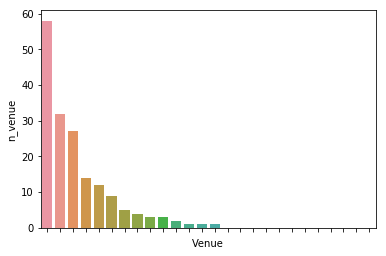

In [18]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
sns.barplot(x='Venue',y='n_venue',data=my_venues.sort_values(by='n_venue',ascending=False))
ax.set_xticklabels('')

In [19]:
my_popular_venue=my_venues[my_venues['n_venue']>=5]
print('The popular venues near the shopping plaza are:',*my_popular_venue['Venue'].values,sep='\n')

The popular venues near the shopping plaza are:
Chipotle Mexican Grill
Ledo Pizza
Dollar Tree
AT&T
7-Eleven
Shell
McDonald's


[]

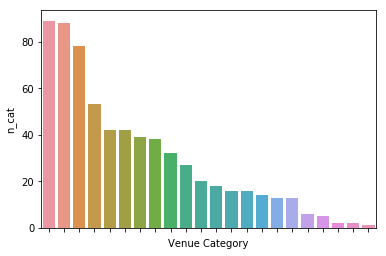

In [77]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
sns.barplot(x='Venue Category',y='n_cat',data=my_venues.sort_values(by='n_cat',ascending=False).drop_duplicates())
ax.set_xticklabels('')

In [74]:
my_popular_cat=my_venues[my_venues['n_cat']>=10]
print('The popular venue categories near the shopping plaza are:',*my_popular_cat['Venue Category'].drop_duplicates().values,sep='\n')

The popular venue categories near the shopping plaza are:
Café
Sandwich Place
Mexican Restaurant
Spa
Pizza Place
Discount Store
Department Store
Mobile Phone Shop
BBQ Joint
Cosmetics Shop
Deli / Bodega
Convenience Store
Gas Station
Construction & Landscaping
Fast Food Restaurant
Home Service
Fried Chicken Joint


## Secondly, find the relationships between pairs of venues/venue categories using k nearest neighbors (knn) model and test

In [22]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [23]:
#Put venues that have 5 or more locations into DataFrame popular_venues
popular=pg_venues.groupby('Venue')['Neighborhood'].count().sort_values(ascending=False)>=5
popular_list=popular.index.to_list()[:popular.sum()]
popular_venues=pg_venues[pg_venues['Venue'].apply(lambda x: x in popular_list)]
popular_venues.shape

(602, 7)

In [24]:
#Put venue categories that have 10 or more locations into DataFrame popular_venue_cat
popular_cat=pg_venues.groupby('Venue Category')['Neighborhood'].count().sort_values(ascending=False)>=10
popular_cat_list=popular_cat.index.to_list()[:popular_cat.sum()]
popular_venue_cat=pg_venues[pg_venues['Venue Category'].apply(lambda x: x in popular_cat_list)]
popular_venue_cat.shape

(1505, 7)

## a. Find relationships between pairs of venues

In [25]:
venues_onehot = pd.get_dummies(popular_venues[['Venue']], prefix="", prefix_sep="")
venues_onehot['Neighborhood'] = popular_venues['Neighborhood'] 
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]
df_venues=venues_onehot.groupby('Neighborhood').mean().transpose()
df_venues.head()

Neighborhood,"Adelphi, MD","Andrews AFB, MD","Beltsville, MD","Berwyn Heights, MD","Bladensburg, MD","Bowie, MD","Calverton, MD","Camp Springs, MD","Cheverly, MD","Chillum, MD",...,"Silver Hill, MD","South Laurel, MD","Suitland, MD","Summerfield, MD","Temple Hills, MD","University Park, MD","Upper Marlboro, MD","Walker Mill, MD","West Laurel, MD","Woodlawn, MD"
7-Eleven,0.285714,0.0,0.045455,0.071429,0.333333,0.000000,0.0,0.166667,1.0,0.153846,...,0.105263,0.0,0.166667,0.0,0.333333,0.090909,0.111111,0.0,0.0,0.0
ALDI,0.000000,0.0,0.045455,0.000000,0.000000,0.000000,0.0,0.166667,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
AT&T,0.000000,0.0,0.000000,0.000000,0.000000,0.043478,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.045455,0.000000,0.0,0.0,0.0
America's Best Contacts & Eyeglasses,0.000000,0.0,0.000000,0.000000,0.000000,0.043478,0.0,0.000000,0.0,0.076923,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
America's Best Wings,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.0,0.000000,...,0.052632,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [26]:
venues=csr_matrix(df_venues.values)
model_knn=NearestNeighbors(metric='cosine',algorithm='auto',n_neighbors=10)
nbr=model_knn.fit(venues)

### Let's test the model with a well-known venue "Starbucks"!

In [27]:
X=df_venues.loc['Starbucks',:].values.reshape(1,-1)
dist,indices=nbr.kneighbors(X)
print('The closest venue to Starbucks are:',*df_venues.iloc[indices.tolist()[0]].index[0:9].values.tolist(),sep='\n')

The closest venue to Starbucks are:
Starbucks
Chipotle Mexican Grill
T-Mobile
Safeway
CVS pharmacy
AT&T
ALDI
Capital One Bank
Target


###  The test seems good! The closest one should be itself with a distance of zero. Also, it makes sense that 'Safeway' is on the list because we know some Safeway has built-in Starbucks! 

## b. Find relationships between pairs of venue categories

In [28]:
cat_onehot = pd.get_dummies(popular_venue_cat[['Venue Category']], prefix="", prefix_sep="")
cat_onehot['Neighborhood'] = popular_venue_cat['Neighborhood'] 
fixed_columns = [cat_onehot.columns[-1]] + list(cat_onehot.columns[:-1])
cat_onehot = cat_onehot[fixed_columns]
df_cat=cat_onehot.groupby('Neighborhood').mean().transpose()
df_cat.head()

Neighborhood,"Accokeek, MD","Adelphi, MD","Andrews AFB, MD","Aquasco, MD","Baden, MD","Beltsville, MD","Berwyn Heights, MD","Bladensburg, MD","Bowie, MD","Brandywine, MD",...,"Springdale, MD","Suitland, MD","Summerfield, MD","Temple Hills, MD","University Park, MD","Upper Marlboro, MD","Walker Mill, MD","West Laurel, MD","Westphalia, MD","Woodlawn, MD"
American Restaurant,0.00,0.0,0.166667,0.0,0.333333,0.023810,0.023256,0.000000,0.016949,0.0,...,0.0,0.0,0.04,0.142857,0.021277,0.071429,0.125,0.0,0.2,0.000000
BBQ Joint,0.25,0.0,0.000000,0.0,0.000000,0.000000,0.023256,0.000000,0.000000,0.5,...,0.0,0.0,0.00,0.000000,0.000000,0.035714,0.000,0.0,0.2,0.038462
Bakery,0.00,0.0,0.000000,0.0,0.000000,0.071429,0.000000,0.043478,0.033898,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.0,0.000000
Bank,0.00,0.0,0.000000,0.0,0.000000,0.071429,0.046512,0.000000,0.033898,0.0,...,0.0,0.0,0.00,0.000000,0.042553,0.000000,0.000,0.0,0.0,0.000000
Breakfast Spot,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.016949,0.0,...,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000,0.0,0.0,0.000000


In [29]:
cat=csr_matrix(df_cat.values)
model_knn=NearestNeighbors(metric='cosine',algorithm='auto',n_neighbors=12)
nbr=model_knn.fit(cat)

### Let's test out with a couple of venue categories!

In [30]:
Cat_name='Hotel'
X=df_cat.loc[Cat_name,:].values.reshape(1,-1)
dist,indices=nbr.kneighbors(X)
print('The closest venue categories to {} are:'.format(Cat_name),*df_cat.iloc[indices.tolist()[0]].index[0:11].values.tolist(),sep='\n')

The closest venue categories to Hotel are:
Hotel
Restaurant
Gas Station
Convenience Store
Italian Restaurant
American Restaurant
Coffee Shop
Pizza Place
Mobile Phone Shop
Breakfast Spot
Gym / Fitness Center


###  It makes sense since hotels usually have built-in restaurants, coffee, convenience store and gym! 

In [31]:
Cat_name='Gym / Fitness Center'
X=df_cat.loc[Cat_name,:].values.reshape(1,-1)
dist,indices=nbr.kneighbors(X)
print('The closest venue categories to {} are:'.format(Cat_name),*df_cat.iloc[indices.tolist()[0]].index[0:6].values.tolist(),sep='\n')

The closest venue categories to Gym / Fitness Center are:
Gym / Fitness Center
Burger Joint
Donut Shop
Mobile Phone Shop
Mexican Restaurant
Bank


###  Have you noticed that there are always food around a gym?!! 

## c. Find relationships between a venue and venue categories

In [51]:
def Recomm_Cat_for_a_Venue(venue_name,df1,n_recomm):
    df_vcat=pd.concat([df1,df_cat],sort=False).fillna(0)
    v_cat=csr_matrix(df_vcat.values)
    model_knn=NearestNeighbors(metric='cosine',algorithm='auto',n_neighbors=n_recomm)
    nbr=model_knn.fit(v_cat)
    X=df_vcat.loc[venue_name,:].values.reshape(1,-1)
    dist,indices=nbr.kneighbors(X)
    print('The closest venue categories to {} are:'.format(venue_name),*df_vcat.iloc[indices.tolist()[0]].index[0:n_recomm].values.tolist(),sep='\n')

### Test again with "Starbucks" to see if the results are consistent with part a.

In [52]:
venue_name='Starbucks'
Recomm_Cat_for_a_Venue(venue_name,df_venues[df_venues.index==venue_name],10)

The closest venue categories to Starbucks are:
Starbucks
Coffee Shop
Mexican Restaurant
Gym / Fitness Center
Bank
Mobile Phone Shop
Pharmacy
Italian Restaurant
Café
Restaurant


###  The first two on the list are Starbucks itself and its category Coffee Shop, which is expected. Mexican Restaurant, Mobile Phone Shop, Bank and Pharmacy are consistent with the recommendations from part a. Maybe Gym and Italian Restaurant can be added to the recommendation list.

<a id='part4'></a>
# 4. Results

## Now, the algorithm will look at the venues/categories near the client's shopping plaza, and suggest venues/categories that are close.

### a. Recommend venues based on the nearby venues

In [34]:
venues=csr_matrix(df_venues.values)
model_knn=NearestNeighbors(metric='cosine',algorithm='auto',n_neighbors=15)
nbr=model_knn.fit(venues)
X=df_venues[df_venues.index.map(lambda x: x in my_popular_venue['Venue'].values)].mean().values.reshape(1,-1)

In [35]:
dist,indices=nbr.kneighbors(X)
print('The closest venues are:',*df_venues.iloc[indices.tolist()[0]].index[0:14].values.tolist(),sep='\n')

The closest venues are:
7-Eleven
Shell
McDonald's
Subway
CVS pharmacy
Rite Aid
Redbox
Domino's Pizza
Dollar Tree
Enterprise Rent-A-Car
Burger King
Wendy's
Chipotle Mexican Grill
Dunkin'


In [36]:
my_popular_venue['Venue']

2     Chipotle Mexican Grill
4                 Ledo Pizza
5                Dollar Tree
8                       AT&T
14                  7-Eleven
19                     Shell
22                McDonald's
Name: Venue, dtype: object

###  Comparing the closest venues and the exsiting venues, it is seen that some of them coincide, which is totally expected. The venues that are on the closest venue list while not on the existing venue list are the ones we want to recommend to the client. It seems CVS and Redbox are good candidates. However, when I double check with google map, I found there already are CVS and redbox next to the shopping plaza that Foursquare didn't include. In a way, it proves our recommender system work. So maybe another fast food place (Subway, Burger King, Wendy's, Dunkin's...) would be recommended. 

### b. Recommend venue categories based on the nearby venues

In [37]:
cat=csr_matrix(df_cat.values)
model_knn=NearestNeighbors(metric='cosine',algorithm='auto',n_neighbors=15)
nbr=model_knn.fit(cat)
X=df_cat[df_cat.index.map(lambda x: x in my_popular_cat['Venue Category'].values)].mean().values.reshape(1,-1)

In [38]:
dist,indices=nbr.kneighbors(X)
print('The closest venue categories are:',*df_cat.iloc[indices.tolist()[0]].index[0:14].values.tolist(),sep='\n')

The closest venue categories are:
Pizza Place
Fast Food Restaurant
Convenience Store
Sandwich Place
Chinese Restaurant
Discount Store
Pharmacy
Gas Station
Fried Chicken Joint
Mobile Phone Shop
Cosmetics Shop
Mexican Restaurant
Rental Car Location
Grocery Store


In [75]:
my_popular_cat['Venue Category'].drop_duplicates()

0                           Café
1                 Sandwich Place
2             Mexican Restaurant
3                            Spa
4                    Pizza Place
5                 Discount Store
7               Department Store
8              Mobile Phone Shop
9                      BBQ Joint
10                Cosmetics Shop
13                 Deli / Bodega
14             Convenience Store
19                   Gas Station
20    Construction & Landscaping
22          Fast Food Restaurant
24                  Home Service
25           Fried Chicken Joint
Name: Venue Category, dtype: object

###  Compare the closest venue categories and the exsiting categories, a Chinese Restrant would be recommended. 

### c. Recommend venue categories based on the nearby venue categories

In [53]:
venue_name='my popular venues'
df=pd.DataFrame(df_venues[df_venues.index.map(lambda x: x in my_popular_venue['Venue'].values)].mean()).transpose()
df.set_index(pd.Index([venue_name]),inplace=True)
Recomm_Cat_for_a_Venue(venue_name,df,15)

The closest venue categories to my popular venues are:
my popular venues
Convenience Store
Fast Food Restaurant
Gas Station
Pizza Place
Sandwich Place
Pharmacy
Restaurant
Mexican Restaurant
Hotel
Italian Restaurant
Chinese Restaurant
Shopping Mall
Bakery
Discount Store


In [76]:
my_popular_cat['Venue Category'].drop_duplicates()

0                           Café
1                 Sandwich Place
2             Mexican Restaurant
3                            Spa
4                    Pizza Place
5                 Discount Store
7               Department Store
8              Mobile Phone Shop
9                      BBQ Joint
10                Cosmetics Shop
13                 Deli / Bodega
14             Convenience Store
19                   Gas Station
20    Construction & Landscaping
22          Fast Food Restaurant
24                  Home Service
25           Fried Chicken Joint
Name: Venue Category, dtype: object

###  Again, Chinese Restrant would be recommended. 

<a id='part5'></a>
# 5. Discussion

## This simple recommender seems working. We would recommend Chinese Restaurant and Fast Food Restaurant (Subway, Burger King, Wendy's, Dunkin's...) to the client. But there are a few problems that may affect the accuracy:

## 1. Some venue information from Foursquare is missing or incorrect. For example, some existing venues are not found, or some venues are assigned to multiple venue categories.

## 2.  There are duplicated venues, because they belong to multiple towns. A better data cleaning can help solve the problem.

## There are also limitations to the recommendations:

## 1. Only popular venues (chained) or venue categories can be recommended. 

## 2. It is hard to recommend an existing venue category even the area may need more venues of the same category.

## 3. Ratings of the venues are not considered for now. 

<a id='part6'></a>
# 6. Conclusion

## In this study, I used item based collaborative filter method to build a recommender system to recommend which venues/venue categories would be added to a client's shopping plaza. I obtained data from Wikipedia and Foursqure API, and built a k nearest neighbors model to analyze the relationship between venues/venue categories in prince-george county, Maryland, where the client's shopping plaza is located. The model was tested with well-known venues and venue categories, and then applied to the client's shopping plaza to make recommendations.  This recommender system can be useful to help landlords/developers make decisions or get inspiring ideas.